# NeuralNetwork.

### Data Preparation.

In [0]:
# imports.
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [0]:
# read in the data.
df = pd.read_csv('https://raw.githubusercontent.com/spotify-song-suggester-1/spotify-app/master/ds/Data/SpotifyTracks_doubleforloop_genre_year.csv',index_col=[0])
# show the data frame.
print(df.shape)
df.head()

(164449, 20)


,artist_name,track_name,track_id,popularity,year,genre,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Gorillaz,On Melancholy Hill,0q6LuUqGLUiCPP1cbdwFs3,75,2010,alternative,0,0.000015,0.689,233867,0.739,0.509000,2,0.0640,-5.810,1,0.0260,120.423,4,0.578
1,Avenged Sevenfold,Nightmare,4UEo1b0wWrtHMC8bVqPiH8,70,2010,alternative,1,0.000318,0.554,374453,0.949,0.000100,2,0.2000,-4.928,1,0.0787,129.984,4,0.233
2,The Black Keys,Howlin' for You,0grFc6klR3hxoHLcgCYsF4,66,2010,alternative,2,0.028000,0.705,191800,0.735,0.078300,11,0.1120,-6.646,1,0.0931,132.627,4,0.448
3,My Darkest Days,Porn Star Dancing,3Q8zopc4ABXhysDb1sgLVW,65,2010,alternative,3,0.013900,0.477,199013,0.917,0.000000,2,0.0756,-3.399,1,0.0837,160.044,4,0.271
4,Volbeat,A Warrior's Call,0hTiTU0yqthnByyZDD3bcc,62,2010,alternative,4,0.000750,0.374,263080,0.903,0.000006,10,0.2440,-4.490,1,0.0825,109.118,3,0.429


In [0]:
# new data frame with encoded genre column.
genreframe = pd.concat([df,pd.get_dummies(df['genre'], prefix='genre')],axis=1)
# show the data frame.
print(genreframe.shape)
genreframe.head()

(164449, 32)


,artist_name,track_name,track_id,popularity,year,genre,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_alternative,genre_country,genre_dance,genre_folk,genre_grunge,genre_indie,genre_jazz,genre_metal,genre_pop,genre_punk,genre_rap,genre_rock
0,Gorillaz,On Melancholy Hill,0q6LuUqGLUiCPP1cbdwFs3,75,2010,alternative,0,0.000015,0.689,233867,0.739,0.509000,2,0.0640,-5.810,1,0.0260,120.423,4,0.578,1,0,0,0,0,0,0,0,0,0,0,0
1,Avenged Sevenfold,Nightmare,4UEo1b0wWrtHMC8bVqPiH8,70,2010,alternative,1,0.000318,0.554,374453,0.949,0.000100,2,0.2000,-4.928,1,0.0787,129.984,4,0.233,1,0,0,0,0,0,0,0,0,0,0,0
2,The Black Keys,Howlin' for You,0grFc6klR3hxoHLcgCYsF4,66,2010,alternative,2,0.028000,0.705,191800,0.735,0.078300,11,0.1120,-6.646,1,0.0931,132.627,4,0.448,1,0,0,0,0,0,0,0,0,0,0,0
3,My Darkest Days,Porn Star Dancing,3Q8zopc4ABXhysDb1sgLVW,65,2010,alternative,3,0.013900,0.477,199013,0.917,0.000000,2,0.0756,-3.399,1,0.0837,160.044,4,0.271,1,0,0,0,0,0,0,0,0,0,0,0
4,Volbeat,A Warrior's Call,0hTiTU0yqthnByyZDD3bcc,62,2010,alternative,4,0.000750,0.374,263080,0.903,0.000006,10,0.2440,-4.490,1,0.0825,109.118,3,0.429,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# show only the audio features.
genreframe.iloc[0,7:20]

acousticness        1.51e-05
danceability           0.689
duration_ms           233867
energy                 0.739
instrumentalness       0.509
key                        2
liveness               0.064
loudness               -5.81
mode                       1
speechiness            0.026
tempo                120.423
time_signature             4
valence                0.578
Name: 0, dtype: object

In [0]:
# set the X_train data on the audio features.
X_train = genreframe.iloc[:,7:20].to_numpy()
# set the standard scalar 
scaler = StandardScaler()
# fit the scalar on the X_train data.
X_scaled = scaler.fit_transform(X_train)
# show the array.
print(X_scaled.shape)
X_scaled

(164449, 13)


array([[-0.81353437,  0.86273319,  0.01422737, ..., -0.07457545,
         0.21919423,  0.52020022],
       [-0.81253793,  0.02764277,  1.61395879, ...,  0.24680209,
         0.21919423, -0.95936143],
       [-0.72147348,  0.96170687, -0.46445403, ...,  0.33564226,
         0.21919423, -0.03731576],
       ...,
       [ 0.35424623,  1.02975127,  0.17080273, ..., -0.0196848 ,
         0.21919423,  1.42080297],
       [-0.80624809, -0.62187201, -1.57989421, ..., -1.07440547,
         0.21919423,  1.22781667],
       [-0.42211418,  1.23388449, -0.24267685, ..., -0.99696024,
         0.21919423, -0.50048289]])

In [0]:
# create a list of the genres.
genres = genreframe.genre.unique().tolist()
genres

['alternative',
 'country',
 'dance',
 'folk',
 'grunge',
 'indie',
 'jazz',
 'metal',
 'pop',
 'punk',
 'rap',
 'rock']

In [0]:
# set the y_train as one hots.
onehots = genreframe.iloc[:,20:]
y_train = onehots.to_numpy()
# show the array.
print(y_train.shape)
y_train

(164449, 12)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### Base Model.

In [0]:
# function for NN model.
def create_model():
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(48, input_dim=13, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(12,activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam()
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model.
model = create_model()
# show the model summary.
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 48)                672       
_________________________________________________________________
dense_32 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_33 (Dense)             (None, 12)                300       
Total params: 2,148
Trainable params: 2,148
Non-trainable params: 0
_________________________________________________________________


In [0]:
# set the model.
model = create_model()
# fit the model and create history.
history = model.fit(X_scaled, y_train, validation_split=0.2, batch_size=200, epochs=20)

In [0]:
# base model accuracy score.
scores = model.evaluate(X_scaled, y_train)

164449/164449 [==============================] - 9s 54us/sample - loss: 1.7989 - acc: 0.3808


#### Base Model Visuals.

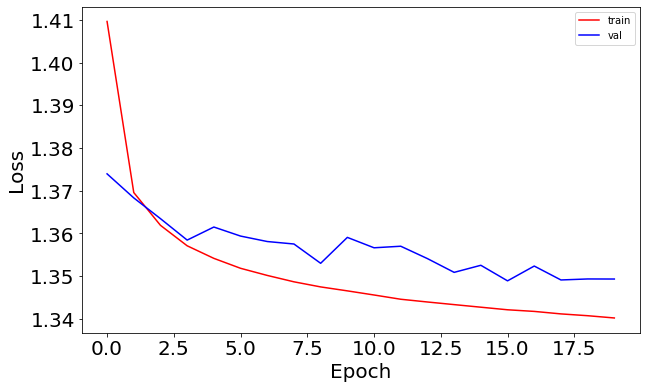

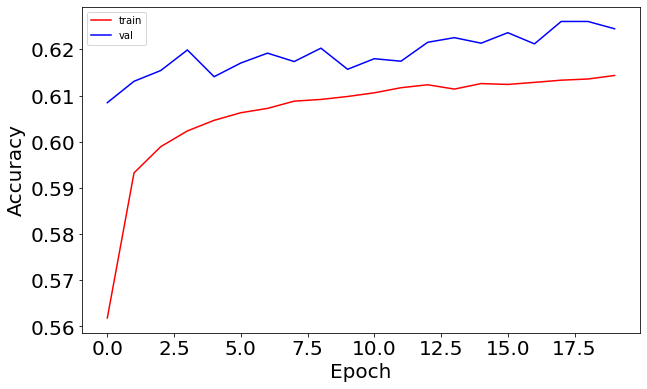

In [0]:
# plot the model loss.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# plot the model accuracy.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Optimizer. *(adam)*

In [0]:
# function for NN model.
def create_model(optimizer='adam'):
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(48, input_dim=13, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(12,activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    return model

In [0]:
# set the model with KerasClassifier.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for optimizer.
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### learning Rate.*(0.001)*

In [0]:
# function for NN model.
def create_model(learn_rate=0.01):
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(48, input_dim=13, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(24, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(12,activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=learn_rate)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model with KerasClassifier.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for learn rate.
learn_rate = [0, 0.001, 0.01, 0.05]
param_grid = dict(learn_rate=learn_rate)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Activation Function.*(relu)*

In [0]:
# function for NN model.
def create_model(activation='relu'):
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(48, input_dim=13, activation=activation))
    model.add(Dense(24, activation=activation))
    model.add(Dense(12,activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model with KerasClassifier.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for activation.
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Hidden Neuron Count.*(192)*

In [0]:
# function for NN model.
def create_model(neurons=1):
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(neurons, input_dim=13, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(12,activation='softmax'))
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model with KerasClassifier.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for neurons.
neurons = [12, 24, 48, 96, 192, 384, 768, 1536, 3072, 6144]
param_grid = dict(neurons=neurons)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Weight Initialization.*(normal)*

In [0]:
# function for NN model.
def create_model(weight_init='uniform'):
    # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer=weight_init, activation='relu'))
    model.add(Dense(96, kernel_initializer=weight_init, activation='relu'))
    model.add(Dense(48, kernel_initializer=weight_init, activation='relu'))
    model.add(Dense(24, kernel_initializer=weight_init, activation='relu'))
    model.add(Dense(12, kernel_initializer=weight_init, activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the KerasClassifier model.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for weight initializer.
weight_init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(weight_init=weight_init)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Dropout Rate.*(0.01)*

In [0]:
# function for NN model.
def create_model(weight_rate=0.0, weight_constraint=0):
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(weight_rate))
    model.add(Dense(96, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(weight_rate))
    model.add(Dense(48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(weight_rate))
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(weight_rate))
    model.add(Dense(12, kernel_initializer='normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the KerasClassifier model.
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for weights and dropout rate.
weight_constraint = [1, 2]
weight_rate = [0.1, 0.2]
param_grid = dict(weight_rate=weight_rate, weight_constraint=weight_constraint)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Batch Size.*(100)*

In [0]:
# function for NN model.
def create_model():
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(96, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(12, kernel_initializer='normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the KerasClassifier model.
model = KerasClassifier(build_fn=create_model, epochs=20, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for batch size.
batch_size = [50, 100, 200, 500, 1000]
param_grid = dict(batch_size=batch_size)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Epochs.*(500)*

In [0]:
# function for NN model.
def create_model():
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(96, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(12, kernel_initializer='normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the KerasClassifier model.
model = KerasClassifier(build_fn=create_model, batch_size=100, validation_split=0.2, verbose=1)

In [0]:
# set the parameters for epochs.
epochs = [100, 200, 500]
param_grid = dict(epochs=epochs)

In [0]:
# set the gridsearch.
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
# fit the model.
grid_result = grid.fit(X_scaled, y_train)
# show the results.
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Final Model.

In [0]:
# function for NN model.
def create_model():
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(192, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(96, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(12, kernel_initializer='normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = Adam(lr=0.001)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model.
model = create_model()
# fit the model, create history.
history = model.fit(X_scaled, y_train, validation_split=0.2, epochs=500, batch_size=100)

In [0]:
# final model accuracy score.
scores = model.evaluate(X_scaled, y_train)

164449/164449 [==============================] - 9s 55us/sample - loss: 1.6750 - acc: 0.4241


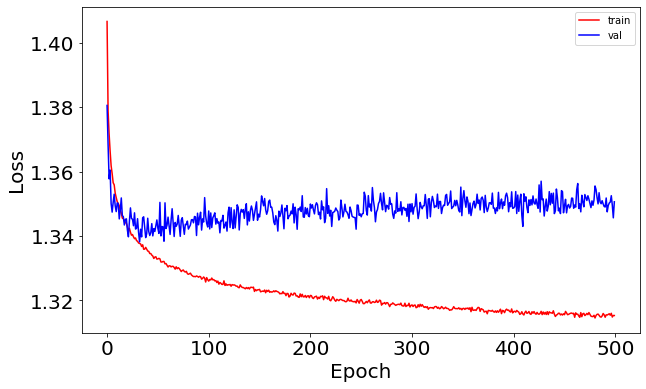

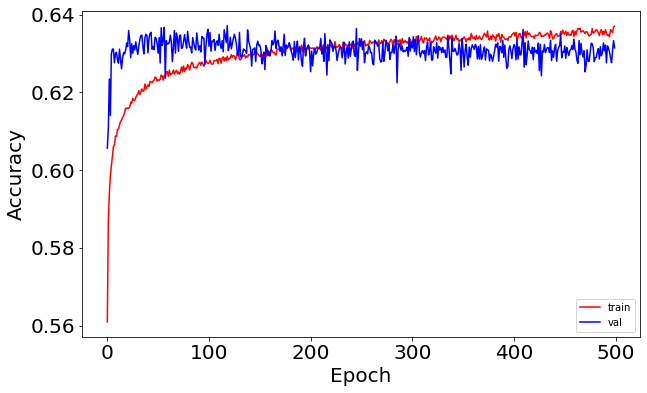

In [0]:
# plot the model loss.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# plot the model accuracy.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)